# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

ResNet 구현하기

## 2-2. Ablation Study
- ablation study(직역 - '제거 연구')
- 딥러닝 논문은 제안한 방법들의 유효함을 증명하기 위해서 해당 방법을 제거한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교한다
- "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험 = 에블레이션 연구

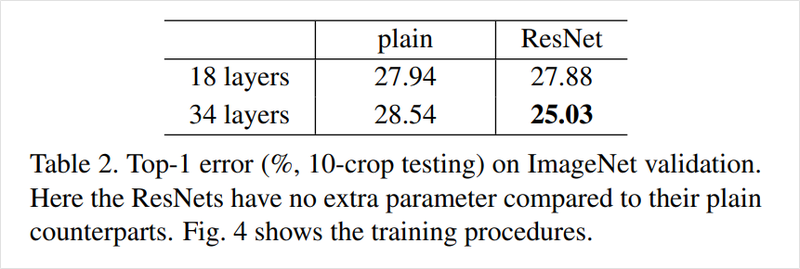

- residual connection 의 애블레이션 연구
- 이미지넷 검증 데이터셋에 대한 top 1 error rate를 지표로 사용해서 일반 네트워크와 resnet비교함
- restnet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때 성능 향상이 가능한 것을 증명하고 있다

## 2-3. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

- cifar 10 데이터셋은 10개 카테고리, 총 6만 장의 이미지가 있다.
- 각 이미지의 가로, 세로는 각각 32 픽셀

### 1) CIFAR-10

In [ ]:
! pip install tensorflow-datasets

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


- tensorflow의 데이터셋은 numpy가 아니므로 ds_train.shape같은 게 없음

### 2) Input Normalization

- Data Normalization : 데이터의 범위를 사용자가 원하는 범위로 제한하는 것
- 이미지 데이터의 픽셀 정보는 0~255사이의 값을 가지는데 이걸 255로 나누어주면 0~1.0사이의 값을 가지게 됨
- 하는 이유 : 머신러닝에서 스케일이 큰 feature의 영향이 비대해지는 것 방지, 딥러닝에서 local optima에 빠질 위험을 줄이는(학습 속도 향상) 것
- 모델에 넣기 전 각 채널별 최댓값인 255로 정규화해서 이미지의 표현이 0과 1 사이로 들어오도록 만들어준다

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 클래스 확인
ds_info.features["label"].num_classes 

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

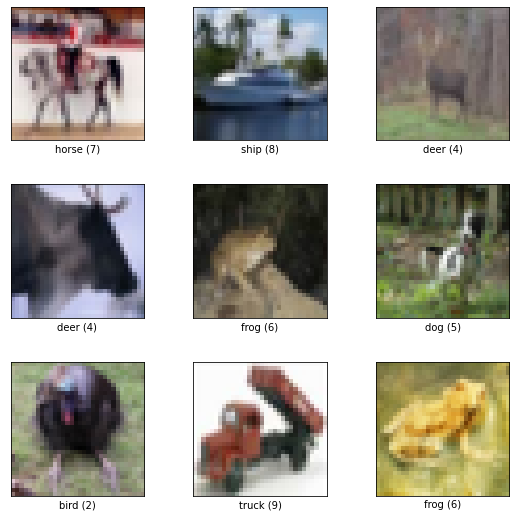

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

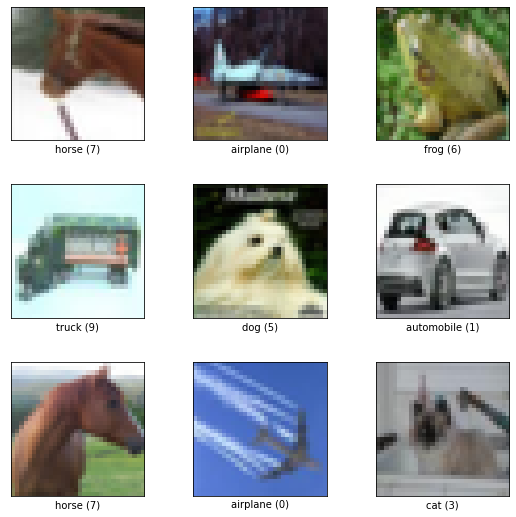

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

## 2-4. Ablation Study 실습 (2) 블록 구성하기

- 모델 구현도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있어야 함
- 최근 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 바꿔 쓸 수 있는 단위 : 블록(block)
- 레이어 : 여러 프레임워크에서 기본적으로 제공하는 단위
- ResNet 18, 34, 50, 101, 152, 다섯 가지 네트워크로 쉽게 변경하기 위해서 기본 구조인 블록을 구현해보자!
- ResNet 바로 구현은 어려우니까 VGG를 먼저 구현

#### VGG 기본 블록 만들기


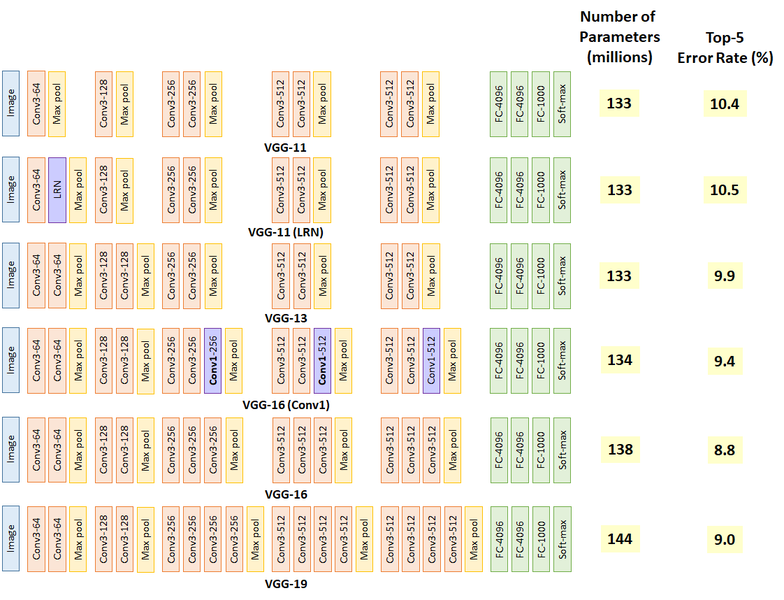

- VGG 16과 19의 기본 구조를 만든다고 가정하고 블록 구현
- VGG는 개략적으로 CNN레이어 여러 개 + Max pooling레이어 한 개
- cnn 대표적인 특징 : 모든 커널 크기가 3 x 3
- 블록 내 CNN레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN레이어의 채널 수는 다를 수 있음
- 블록에 따라 cnn레이어의 개수도 달라진다
- 블록 마지막에는 항상 Max pooling레이어가 붙는다
- 결국 블록은 CNN레이어 n개 + max pooling 레이어 1개 
- CNN레이어 수와 채널을 조절 할 수 있어야 한다


- block_num : 레이어의 이름을 붙이기 위해 추가
- input_shape : summary 출력


In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,    # block_num : 레이어의 이름을 붙이기 위해 추가
                   ):
    # 입력 레이어
    x = input_layer                 

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

- VGG블록 추가 함수를 이용해서 input_layer에 추가를 해보자!
- 입력 레이어 : (32, 32, 3)
- 입력 레이어를 인자로 받아 build_vgg_block()은 블록의 레이어를 만들고 출력값을 얻을 수 있다
- 케라스의 model 클래스에서 input과 output을 정의해주고 간단히 블록의 모델을 확인해보자

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_______________________________________________________

## 2-5. Ablation Study 실습 (3) VGG Complete Model
- 이제 기본적인 블록을 만들 수 있는 함수가 있으니까 이걸 합쳐서 전체 모델을 만들 수 있도록 해보자


### 1) VGG-16

- 블록 내의 CNN레이어 수와 채널 수는 블록마다 달라짐
- 이거는 vgg 16, 19에 따라 달라지므로 함수에 전달 되어야 한다
- 여기서는 각 블록 별 CNN수와 채널을 리스트로 전달

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

### 2) VGG-19
구성을 변경해서 19 구현

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## 2-6. Ablation Study 실습 (4) VGG-16 vs VGG-19
- 데이터셋과 모델의 성능 비교를 위해 모델 훈련 및 평가
- VGG는 레이어의 차이를 위해 16과 19비교

In [ ]:
BATCH_SIZE = 256
EPOCH = 40

In [ ]:
# data load
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- 16 모델을 만들고 훈련시킨다

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 6008s 31s/step - loss: 2.2184 - accuracy: 0.1790 - val_loss: 2.1098 - val_accuracy: 0.2203
Epoch 2/15
167/195 [========================>.....] - ETA: 13:20 - loss: 2.0317 - accuracy: 0.2600

- 19 훈련
(파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸립니다. Epoch 수나 BATCH_SIZE를 잘 조절해 주세요)

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 24s 96ms/step - loss: 2.2336 - accuracy: 0.1677 - val_loss: 2.1340 - val_accuracy: 0.2073
Epoch 2/40
195/195 [==============================] - 18s 95ms/step - loss: 2.0523 - accuracy: 0.2486 - val_loss: 1.9601 - val_accuracy: 0.2864
Epoch 3/40
195/195 [==============================] - 19s 96ms/step - loss: 1.9034 - accuracy: 0.3087 - val_loss: 1.8331 - val_accuracy: 0.3305
Epoch 4/40
195/195 [==============================] - 18s 95ms/step - loss: 1.7801 - accuracy: 0.3544 - val_loss: 1.7070 - val_accuracy: 0.3672
Epoch 5/40
195/195 [==============================] - 18s 95ms/step - loss: 1.6908 - accuracy: 0.3858 - val_loss: 1.6996 - val_accuracy: 0.3743
Epoch 6/40
195/195 [==============================] - 19s 97ms/step - loss: 1.6318 - accuracy: 0.4111 - val_loss: 1.5834 - val_accuracy: 0.4146
Epoch 7/40
195/195 [==============================] - 19s 95ms/step - loss: 1.5696 - accuracy: 0.4304 - val_loss: 1.5528 - val_accuracy: 0.4462
Epo

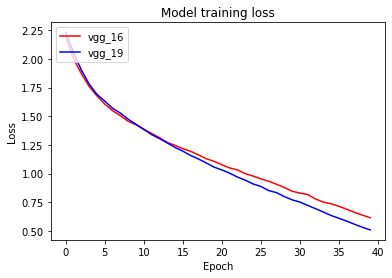

In [ ]:
# 그래프 그리고 비교(훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교)
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

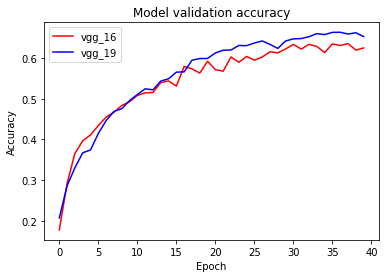

In [ ]:
# 검증 정확도(validation accuracy)를 비교
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()